In [2]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from numpy.linalg import norm

[2.18640038]


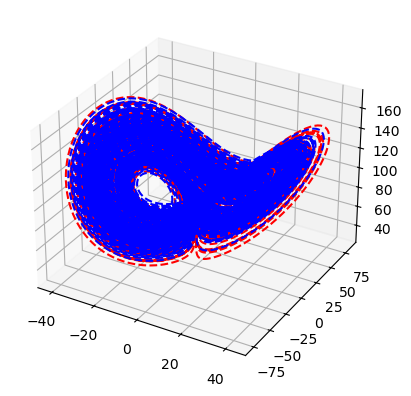

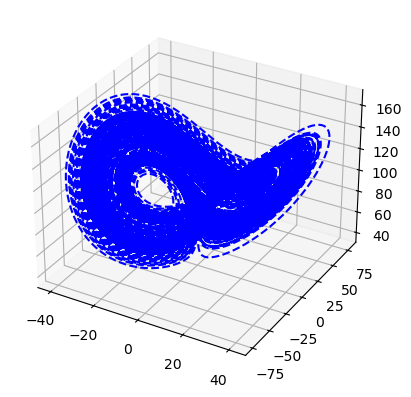

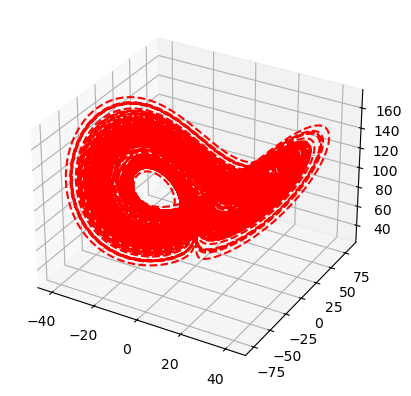

In [8]:
alphaseries = np.array([100])

#alphaseries = np.array([0.01, 1, 100, 1000, 2000, 3000])
avgseries = []
n = 1000  # reservoir size
m = 3

sigma = 10
rho = 99.65
beta = 2.66667


mu = 1.2
lam = 0.000001

tau = 10

# Generate sparse reservoir matrix A1
A1 = sp.random(n, n, density=6/n, format='csr')
A1 = A1 - 0.5 * np.sign(A1.toarray())
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix
A = sp.csr_matrix(A1)

Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

r = 0.5 - 1.0 * np.random.rand(n)

x, y, z = -7.45, -3.03, 0.01

T = 100
dt = 0.002

ntraining = int(T / dt)

R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

for t in range(ntraining):
    
    u = np.array([x, y, z])
    R[:, t] = r

    fx = np.cos(0.05 * dt * t)
    fy = np.sin(0.05 * dt * t)
    f[0, t] = fx
    f[1, t] = fy

    xp = sigma * (y - x) + fx
    yp = x * (rho - z) - y + fy
    zp = x * y - beta * z

    x += dt * xp
    y += dt * yp
    z += dt * zp

    r = np.tanh(A.dot(r) + Win.dot(u) + 1)

Wout = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))

gtemp = np.array([x, y, z])

ndist = int(200 / dt)

for alpha in alphaseries:
    #np.random.seed(0)

    

    # xross = np.zeros(ndist + 1)
    # yross = np.zeros(ndist + 1)
    # zross = np.zeros(ndist + 1)

    # xross[0] = -7.45
    # yross[0] = -3.03
    # zross[0] = 0.01


    gx = np.zeros(ndist)
    gy = np.zeros(ndist)

    ux = np.zeros(ndist + 1)
    uy = np.zeros(ndist + 1)

    vx = np.zeros(ndist + 1)
    vy = np.zeros(ndist + 1)


    gpredx = np.zeros(ndist)
    gpredy = np.zeros(ndist)

    xplot = np.zeros(ndist)
    yplot = np.zeros(ndist)
    zplot = np.zeros(ndist)

    xplotwithout = np.zeros(ndist)
    yplotwithout = np.zeros(ndist)
    zplotwithout = np.zeros(ndist)

    xwithout, ywithout, zwithout = x, y, z

    for t in range(ndist):

        # xrossdot = - yross[t] - zross[t]
        # yrossdot = xross[t] + 0.2 * yross[t]
        # zrossdot = 0.2 + zross[t] * (xross[t] - 5.7)

        # xross[t + 1] = xross[t] + dt * xrossdot
        # yross[t + 1] = yross[t] + dt * yrossdot
        # zross[t + 1] = zross[t] + dt * zrossdot
    
        gy[t] = x / 2

    
        ux[t] = gtemp[0] 
        uy[t] = gtemp[1]



        vx[t + 1] = vx[t] + dt / tau * (ux[t] - vx[t])
        vy[t + 1] = vy[t] + dt / tau * (uy[t] - vy[t])

        xp = sigma * (y - x) + gx[t] - alpha * vx[t]
        yp = x * (rho - z) - y + gy[t] - alpha * vy[t]
        zp = x * y - beta * z

        x += dt * xp
        y += dt * yp
        z += dt * zp
        
        xplot[t] = x
        yplot[t] = y
        zplot[t] = z

        xpwithout = sigma * (ywithout - xwithout) 
        ypwithout = xwithout * (rho - zwithout)
        zpwithout = xwithout * ywithout - beta * zwithout

        xwithout += dt * xpwithout
        ywithout += dt * ypwithout
        zwithout += dt * zpwithout
        
        xplotwithout[t] = xwithout
        yplotwithout[t] = ywithout
        zplotwithout[t] = zwithout

        gtemp = np.array([x, y, z])
        r = np.tanh(A.dot(r) + Win.dot(gtemp) + 1)
        gtemp = Wout.dot(r)
        gpredx[t] = gtemp[0]
        gpredy[t] = gtemp[1]


    pwithout = np.vstack((xplotwithout, yplotwithout, zplotwithout))
    pwith = np.vstack((xplot, yplot, zplot))
    pwithout = pwithout[:, -5000:]
    pwith = pwith[:, -5000:]

    sumdist = 0
    avg = 0
    for i in range(pwith.shape[1]):
        mindist = norm(pwith[:, i] - pwithout[:, 0])
        for j in range(pwithout.shape[1]):
            if norm(pwith[:, i] - pwithout[:, j]) < mindist :
                mindist = norm(pwith[:, i] - pwithout[:, j])
        sumdist += mindist

    avg = sumdist/pwith.shape[1]
    avgseries.append(avg)

avgseries = np.array(avgseries)

print(avgseries)


# fig = plt.figure()
# ax = plt.gca()
# ax.plot(alphaseries ,avgseries, 'o', c='blue', markeredgecolor='none')
# ax.set_yscale('log')
# ax.set_xscale('log')


plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xplot, yplot, zplot, 'r--')
ax.plot3D(xplotwithout, yplotwithout, zplotwithout, 'b--')
plt.show()

plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xplotwithout, yplotwithout, zplotwithout, 'b--')
plt.show()

plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xplot, yplot, zplot, 'r--')
plt.show()

[4.8626652]


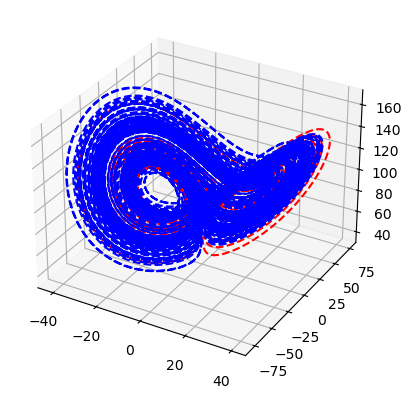

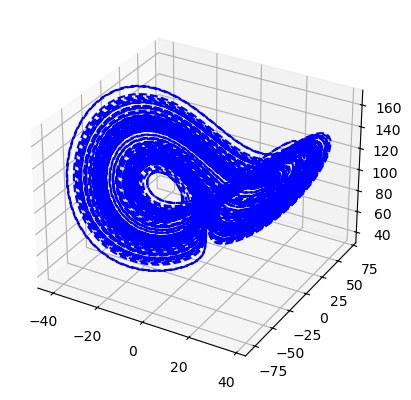

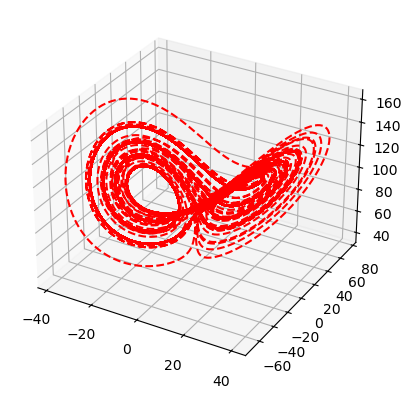

In [9]:
alphaseries = np.array([100])

#alphaseries = np.array([0.01, 1, 100, 1000, 2000, 3000])
avgseries = []
n = 1000  # reservoir size
m = 3

sigma = 10
rho = 99
beta = 2.66667


mu = 1.2
lam = 0.000001

tau = 10

# Generate sparse reservoir matrix A1
A1 = sp.random(n, n, density=6/n, format='csr')
A1 = A1 - 0.5 * np.sign(A1.toarray())
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix
A = sp.csr_matrix(A1)

Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

r = 0.5 - 1.0 * np.random.rand(n)

x, y, z = -7.45, -3.03, 0.01

T = 100
dt = 0.002

ntraining = int(T / dt)

R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

for t in range(ntraining):
    
    u = np.array([x, y, z])
    R[:, t] = r

    fx = np.cos(0.05 * dt * t)
    fy = np.sin(0.05 * dt * t)
    f[0, t] = fx
    f[1, t] = fy

    xp = sigma * (y - x) + fx
    yp = x * (rho - z) - y + fy
    zp = x * y - beta * z

    x += dt * xp
    y += dt * yp
    z += dt * zp

    r = np.tanh(A.dot(r) + Win.dot(u) + 1)

Wout = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))

gtemp = np.array([x, y, z])

ndist = int(200 / dt)

for alpha in alphaseries:
    #np.random.seed(0)

    

    # xross = np.zeros(ndist + 1)
    # yross = np.zeros(ndist + 1)
    # zross = np.zeros(ndist + 1)

    # xross[0] = -7.45
    # yross[0] = -3.03
    # zross[0] = 0.01


    gx = np.zeros(ndist)
    gy = np.zeros(ndist)

    ux = np.zeros(ndist + 1)
    uy = np.zeros(ndist + 1)

    vx = np.zeros(ndist + 1)
    vy = np.zeros(ndist + 1)


    gpredx = np.zeros(ndist)
    gpredy = np.zeros(ndist)

    xplot = np.zeros(ndist)
    yplot = np.zeros(ndist)
    zplot = np.zeros(ndist)

    xplotwithout = np.zeros(ndist)
    yplotwithout = np.zeros(ndist)
    zplotwithout = np.zeros(ndist)

    xwithout, ywithout, zwithout = x, y, z

    for t in range(ndist):

        # xrossdot = - yross[t] - zross[t]
        # yrossdot = xross[t] + 0.2 * yross[t]
        # zrossdot = 0.2 + zross[t] * (xross[t] - 5.7)

        # xross[t + 1] = xross[t] + dt * xrossdot
        # yross[t + 1] = yross[t] + dt * yrossdot
        # zross[t + 1] = zross[t] + dt * zrossdot
    
        gy[t] = x / 2

    
        ux[t] = gtemp[0] 
        uy[t] = gtemp[1]



        vx[t + 1] = vx[t] + dt / tau * (ux[t] - vx[t])
        vy[t + 1] = vy[t] + dt / tau * (uy[t] - vy[t])

        xp = sigma * (y - x) + gx[t] - alpha * vx[t]
        yp = x * (rho - z) - y + gy[t] - alpha * vy[t]
        zp = x * y - beta * z

        x += dt * xp
        y += dt * yp
        z += dt * zp
        
        xplot[t] = x
        yplot[t] = y
        zplot[t] = z

        xpwithout = sigma * (ywithout - xwithout) 
        ypwithout = xwithout * (rho - zwithout)
        zpwithout = xwithout * ywithout - beta * zwithout

        xwithout += dt * xpwithout
        ywithout += dt * ypwithout
        zwithout += dt * zpwithout
        
        xplotwithout[t] = xwithout
        yplotwithout[t] = ywithout
        zplotwithout[t] = zwithout

        gtemp = np.array([x, y, z])
        r = np.tanh(A.dot(r) + Win.dot(gtemp) + 1)
        gtemp = Wout.dot(r)
        gpredx[t] = gtemp[0]
        gpredy[t] = gtemp[1]


    pwithout = np.vstack((xplotwithout, yplotwithout, zplotwithout))
    pwith = np.vstack((xplot, yplot, zplot))
    pwithout = pwithout[:, -1000:]
    pwith = pwith[:, -1000:]

    sumdist = 0
    avg = 0
    for i in range(pwith.shape[1]):
        mindist = norm(pwith[:, i] - pwithout[:, 0])
        for j in range(pwithout.shape[1]):
            if norm(pwith[:, i] - pwithout[:, j]) < mindist :
                mindist = norm(pwith[:, i] - pwithout[:, j])
        sumdist += mindist

    avg = sumdist/pwith.shape[1]
    avgseries.append(avg)

avgseries = np.array(avgseries)

print(avgseries)


# fig = plt.figure()
# ax = plt.gca()
# ax.plot(alphaseries ,avgseries, 'o', c='blue', markeredgecolor='none')
# ax.set_yscale('log')
# ax.set_xscale('log')


plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xplot, yplot, zplot, 'r--')
ax.plot3D(xplotwithout, yplotwithout, zplotwithout, 'b--')
plt.show()

plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xplotwithout, yplotwithout, zplotwithout, 'b--')
plt.show()

plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xplot, yplot, zplot, 'r--')
plt.show()

[1.93053293]


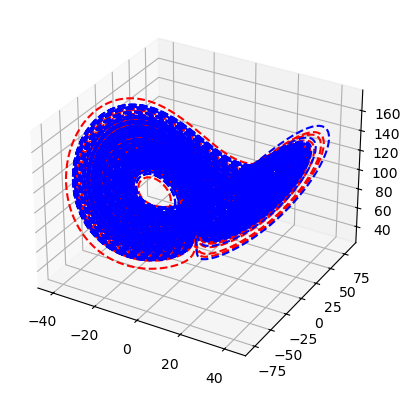

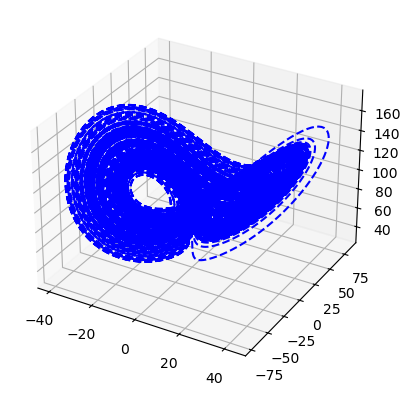

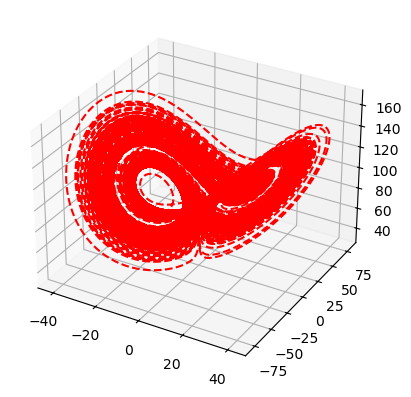

In [10]:
alphaseries = np.array([100])

#alphaseries = np.array([0.01, 1, 100, 1000, 2000, 3000])
avgseries = []
n = 1000  # reservoir size
m = 3

sigma = 10
rho = 99.2
beta = 2.66667


mu = 1.2
lam = 0.000001

tau = 10

# Generate sparse reservoir matrix A1
A1 = sp.random(n, n, density=6/n, format='csr')
A1 = A1 - 0.5 * np.sign(A1.toarray())
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix
A = sp.csr_matrix(A1)

Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

r = 0.5 - 1.0 * np.random.rand(n)

x, y, z = -7.45, -3.03, 0.01

T = 100
dt = 0.002

ntraining = int(T / dt)

R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

for t in range(ntraining):
    
    u = np.array([x, y, z])
    R[:, t] = r

    fx = np.cos(0.05 * dt * t)
    fy = np.sin(0.05 * dt * t)
    f[0, t] = fx
    f[1, t] = fy

    xp = sigma * (y - x) + fx
    yp = x * (rho - z) - y + fy
    zp = x * y - beta * z

    x += dt * xp
    y += dt * yp
    z += dt * zp

    r = np.tanh(A.dot(r) + Win.dot(u) + 1)

Wout = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))

gtemp = np.array([x, y, z])

ndist = int(200 / dt)

for alpha in alphaseries:
    #np.random.seed(0)

    

    # xross = np.zeros(ndist + 1)
    # yross = np.zeros(ndist + 1)
    # zross = np.zeros(ndist + 1)

    # xross[0] = -7.45
    # yross[0] = -3.03
    # zross[0] = 0.01


    gx = np.zeros(ndist)
    gy = np.zeros(ndist)

    ux = np.zeros(ndist + 1)
    uy = np.zeros(ndist + 1)

    vx = np.zeros(ndist + 1)
    vy = np.zeros(ndist + 1)


    gpredx = np.zeros(ndist)
    gpredy = np.zeros(ndist)

    xplot = np.zeros(ndist)
    yplot = np.zeros(ndist)
    zplot = np.zeros(ndist)

    xplotwithout = np.zeros(ndist)
    yplotwithout = np.zeros(ndist)
    zplotwithout = np.zeros(ndist)

    xwithout, ywithout, zwithout = x, y, z

    for t in range(ndist):

        # xrossdot = - yross[t] - zross[t]
        # yrossdot = xross[t] + 0.2 * yross[t]
        # zrossdot = 0.2 + zross[t] * (xross[t] - 5.7)

        # xross[t + 1] = xross[t] + dt * xrossdot
        # yross[t + 1] = yross[t] + dt * yrossdot
        # zross[t + 1] = zross[t] + dt * zrossdot
    
        gy[t] = x / 2

    
        ux[t] = gtemp[0] 
        uy[t] = gtemp[1]



        vx[t + 1] = vx[t] + dt / tau * (ux[t] - vx[t])
        vy[t + 1] = vy[t] + dt / tau * (uy[t] - vy[t])

        xp = sigma * (y - x) + gx[t] - alpha * vx[t]
        yp = x * (rho - z) - y + gy[t] - alpha * vy[t]
        zp = x * y - beta * z

        x += dt * xp
        y += dt * yp
        z += dt * zp
        
        xplot[t] = x
        yplot[t] = y
        zplot[t] = z

        xpwithout = sigma * (ywithout - xwithout) 
        ypwithout = xwithout * (rho - zwithout)
        zpwithout = xwithout * ywithout - beta * zwithout

        xwithout += dt * xpwithout
        ywithout += dt * ypwithout
        zwithout += dt * zpwithout
        
        xplotwithout[t] = xwithout
        yplotwithout[t] = ywithout
        zplotwithout[t] = zwithout

        gtemp = np.array([x, y, z])
        r = np.tanh(A.dot(r) + Win.dot(gtemp) + 1)
        gtemp = Wout.dot(r)
        gpredx[t] = gtemp[0]
        gpredy[t] = gtemp[1]


    pwithout = np.vstack((xplotwithout, yplotwithout, zplotwithout))
    pwith = np.vstack((xplot, yplot, zplot))
    pwithout = pwithout[:, -1000:]
    pwith = pwith[:, -1000:]

    sumdist = 0
    avg = 0
    for i in range(pwith.shape[1]):
        mindist = norm(pwith[:, i] - pwithout[:, 0])
        for j in range(pwithout.shape[1]):
            if norm(pwith[:, i] - pwithout[:, j]) < mindist :
                mindist = norm(pwith[:, i] - pwithout[:, j])
        sumdist += mindist

    avg = sumdist/pwith.shape[1]
    avgseries.append(avg)

avgseries = np.array(avgseries)

print(avgseries)


# fig = plt.figure()
# ax = plt.gca()
# ax.plot(alphaseries ,avgseries, 'o', c='blue', markeredgecolor='none')
# ax.set_yscale('log')
# ax.set_xscale('log')


plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xplot, yplot, zplot, 'r--')
ax.plot3D(xplotwithout, yplotwithout, zplotwithout, 'b--')
plt.show()

plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xplotwithout, yplotwithout, zplotwithout, 'b--')
plt.show()

plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xplot, yplot, zplot, 'r--')
plt.show()

[8.46490254]


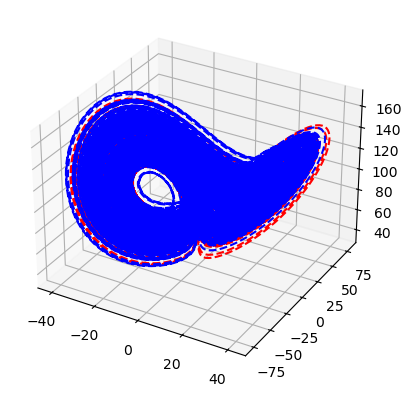

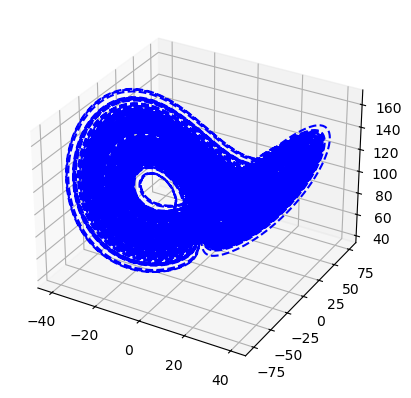

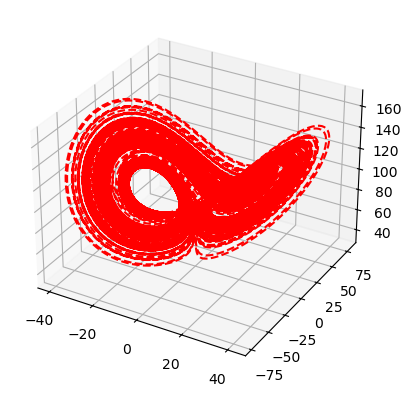

In [11]:
alphaseries = np.array([100])

#alphaseries = np.array([0.01, 1, 100, 1000, 2000, 3000])
avgseries = []
n = 1000  # reservoir size
m = 3

sigma = 10
rho = 100.5
beta = 2.66667


mu = 1.2
lam = 0.000001

tau = 10

# Generate sparse reservoir matrix A1
A1 = sp.random(n, n, density=6/n, format='csr')
A1 = A1 - 0.5 * np.sign(A1.toarray())
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix
A = sp.csr_matrix(A1)

Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

r = 0.5 - 1.0 * np.random.rand(n)

x, y, z = -7.45, -3.03, 0.01

T = 100
dt = 0.002

ntraining = int(T / dt)

R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

for t in range(ntraining):
    
    u = np.array([x, y, z])
    R[:, t] = r

    fx = np.cos(0.05 * dt * t)
    fy = np.sin(0.05 * dt * t)
    f[0, t] = fx
    f[1, t] = fy

    xp = sigma * (y - x) + fx
    yp = x * (rho - z) - y + fy
    zp = x * y - beta * z

    x += dt * xp
    y += dt * yp
    z += dt * zp

    r = np.tanh(A.dot(r) + Win.dot(u) + 1)

Wout = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))

gtemp = np.array([x, y, z])

ndist = int(200 / dt)

for alpha in alphaseries:
    #np.random.seed(0)

    

    # xross = np.zeros(ndist + 1)
    # yross = np.zeros(ndist + 1)
    # zross = np.zeros(ndist + 1)

    # xross[0] = -7.45
    # yross[0] = -3.03
    # zross[0] = 0.01


    gx = np.zeros(ndist)
    gy = np.zeros(ndist)

    ux = np.zeros(ndist + 1)
    uy = np.zeros(ndist + 1)

    vx = np.zeros(ndist + 1)
    vy = np.zeros(ndist + 1)


    gpredx = np.zeros(ndist)
    gpredy = np.zeros(ndist)

    xplot = np.zeros(ndist)
    yplot = np.zeros(ndist)
    zplot = np.zeros(ndist)

    xplotwithout = np.zeros(ndist)
    yplotwithout = np.zeros(ndist)
    zplotwithout = np.zeros(ndist)

    xwithout, ywithout, zwithout = x, y, z

    for t in range(ndist):

        # xrossdot = - yross[t] - zross[t]
        # yrossdot = xross[t] + 0.2 * yross[t]
        # zrossdot = 0.2 + zross[t] * (xross[t] - 5.7)

        # xross[t + 1] = xross[t] + dt * xrossdot
        # yross[t + 1] = yross[t] + dt * yrossdot
        # zross[t + 1] = zross[t] + dt * zrossdot
    
        gy[t] = x / 2

    
        ux[t] = gtemp[0] 
        uy[t] = gtemp[1]



        vx[t + 1] = vx[t] + dt / tau * (ux[t] - vx[t])
        vy[t + 1] = vy[t] + dt / tau * (uy[t] - vy[t])

        xp = sigma * (y - x) + gx[t] - alpha * vx[t]
        yp = x * (rho - z) - y + gy[t] - alpha * vy[t]
        zp = x * y - beta * z

        x += dt * xp
        y += dt * yp
        z += dt * zp
        
        xplot[t] = x
        yplot[t] = y
        zplot[t] = z

        xpwithout = sigma * (ywithout - xwithout) 
        ypwithout = xwithout * (rho - zwithout)
        zpwithout = xwithout * ywithout - beta * zwithout

        xwithout += dt * xpwithout
        ywithout += dt * ypwithout
        zwithout += dt * zpwithout
        
        xplotwithout[t] = xwithout
        yplotwithout[t] = ywithout
        zplotwithout[t] = zwithout

        gtemp = np.array([x, y, z])
        r = np.tanh(A.dot(r) + Win.dot(gtemp) + 1)
        gtemp = Wout.dot(r)
        gpredx[t] = gtemp[0]
        gpredy[t] = gtemp[1]


    pwithout = np.vstack((xplotwithout, yplotwithout, zplotwithout))
    pwith = np.vstack((xplot, yplot, zplot))
    pwithout = pwithout[:, -1000:]
    pwith = pwith[:, -1000:]

    sumdist = 0
    avg = 0
    for i in range(pwith.shape[1]):
        mindist = norm(pwith[:, i] - pwithout[:, 0])
        for j in range(pwithout.shape[1]):
            if norm(pwith[:, i] - pwithout[:, j]) < mindist :
                mindist = norm(pwith[:, i] - pwithout[:, j])
        sumdist += mindist

    avg = sumdist/pwith.shape[1]
    avgseries.append(avg)

avgseries = np.array(avgseries)

print(avgseries)


# fig = plt.figure()
# ax = plt.gca()
# ax.plot(alphaseries ,avgseries, 'o', c='blue', markeredgecolor='none')
# ax.set_yscale('log')
# ax.set_xscale('log')


plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xplot, yplot, zplot, 'r--')
ax.plot3D(xplotwithout, yplotwithout, zplotwithout, 'b--')
plt.show()

plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xplotwithout, yplotwithout, zplotwithout, 'b--')
plt.show()

plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xplot, yplot, zplot, 'r--')
plt.show()

In [49]:
times = np.linspace(100, 200, ndist + 1)
times


array([100.   , 100.001, 100.002, ..., 199.998, 199.999, 200.   ])

[5.87215831]


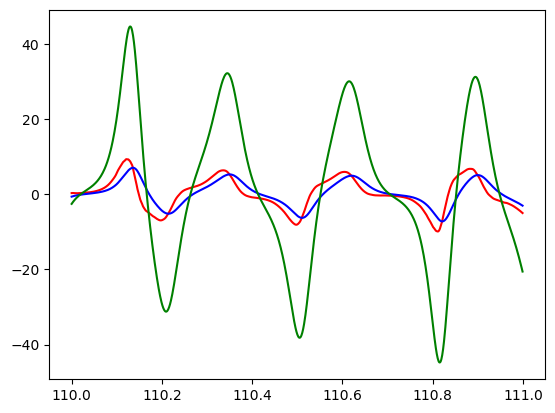

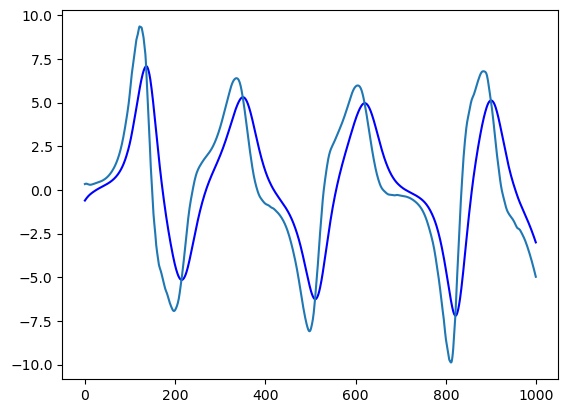

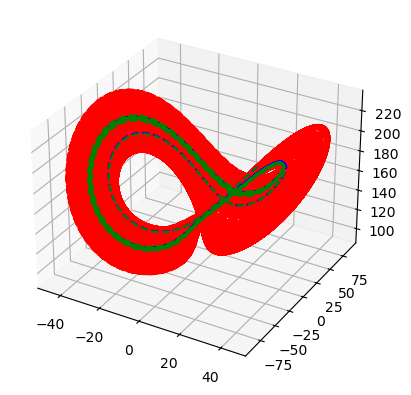

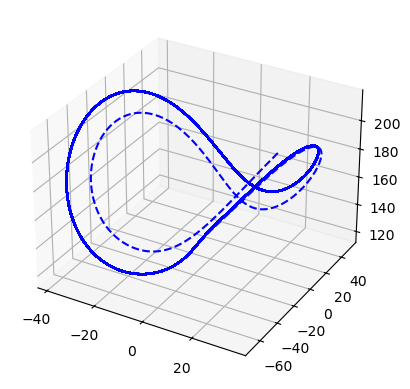

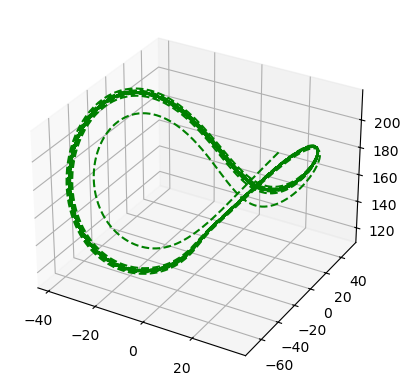

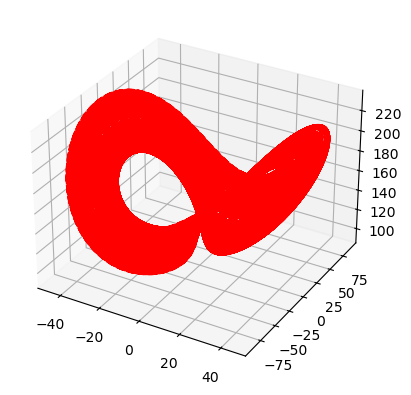

In [55]:
alphaseries = np.array([5])

#alphaseries = np.array([0.01, 1, 100, 1000, 2000, 3000])
avgseries = []
n = 1000  # reservoir size
m = 3

sigma = 10
rho = 159 
beta = 8/3


mu = 1.2
lam = 0.000001

tau = 0.05

# Generate sparse reservoir matrix A1
A1 = sp.random(n, n, density=6/n, format='csr')
A1 = A1 - 0.5 * np.sign(A1.toarray())
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix
A = sp.csr_matrix(A1)

Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

r = 0.5 - 1.0 * np.random.rand(n)

x, y, z = -7.45, -3.03, 0.01

T = 100
dt = 0.002

ntraining = int(T / dt)

R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))




for t in range(ntraining):
    
    u = np.array([x, y, z])
    R[:, t] = r

    fx = np.cos(0.05 * dt * t)
    fy = np.sin(0.05 * dt * t)
    
    f[0, t] = fx
    f[1, t] = fy

    xp = sigma * (y - x) + fx
    yp = x * (rho - z) - y + fy
    zp = x * y - beta * z

    x += dt * xp
    y += dt * yp
    z += dt * zp

    r = np.tanh(A.dot(r) + Win.dot(u) + 1)



Wout = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))


gtemp = np.array([x, y, z])

ndist = int(200 / dt)

for alpha in alphaseries:
    #np.random.seed(0)

    

    # xross = np.zeros(ndist + 1)
    # yross = np.zeros(ndist + 1)
    # zross = np.zeros(ndist + 1)

    # xross[0] = -7.45
    # yross[0] = -3.03
    # zross[0] = 0.01


    gx = np.zeros(ndist)
    gy = np.zeros(ndist)

    ux = np.zeros(ndist + 1)
    uy = np.zeros(ndist + 1)

    vx = np.zeros(ndist + 1)
    vy = np.zeros(ndist + 1)


    gpredx = np.zeros(ndist)
    gpredy = np.zeros(ndist)

    xplot = np.zeros(ndist)
    yplot = np.zeros(ndist)
    zplot = np.zeros(ndist)

    xplotwithout = np.zeros(ndist)
    yplotwithout = np.zeros(ndist)
    zplotwithout = np.zeros(ndist)

    xraw = np.zeros(ndist)
    yraw = np.zeros(ndist)
    zraw = np.zeros(ndist)


    xwithout, ywithout, zwithout = x, y, z
    xrawwithout, yrawwithout, zrawwithout = x, y, z

    for t in range(ndist):

        # xrossdot = - yross[t] - zross[t]
        # yrossdot = xross[t] + 0.2 * yross[t]
        # zrossdot = 0.2 + zross[t] * (xross[t] - 5.7)

        # xross[t + 1] = xross[t] + dt * xrossdot
        # yross[t + 1] = yross[t] + dt * yrossdot
        # zross[t + 1] = zross[t] + dt * zrossdot
    
        gy[t] = x

    
        ux[t] = gtemp[0] 
        uy[t] = gtemp[1]



        vx[t + 1] = vx[t] + (dt / tau) * (ux[t] - vx[t])
        vy[t + 1] = vy[t] + (dt / tau) * (uy[t] - vy[t])

        xp = sigma * (y - x) + gx[t] - alpha * vx[t]
        yp = x * (rho - z) - y + gy[t] - alpha * vy[t]
        zp = x * y - beta * z

        x += dt * xp
        y += dt * yp
        z += dt * zp
        
        xplot[t] = x
        yplot[t] = y
        zplot[t] = z

        xpwithout = sigma * (ywithout - xwithout) 
        ypwithout = xwithout * ((rho + 1) - zwithout)
        zpwithout = xwithout * ywithout - beta * zwithout

        xwithout += dt * xpwithout
        ywithout += dt * ypwithout
        zwithout += dt * zpwithout
        
        xplotwithout[t] = xwithout
        yplotwithout[t] = ywithout
        zplotwithout[t] = zwithout


        xprawwithout = sigma * (yrawwithout - xrawwithout)
        yprawwithout = xrawwithout * (rho - zrawwithout)
        zprawwithout = xrawwithout * yrawwithout - beta * zrawwithout

        xrawwithout += dt * xprawwithout
        yrawwithout += dt * yprawwithout
        zrawwithout += dt * zprawwithout

        xraw[t] = xrawwithout
        yraw[t] = yrawwithout
        zraw[t] = zrawwithout

        gtemp = np.array([x, y, z])
        r = np.tanh(A.dot(r) + Win.dot(gtemp) + 1)
        gtemp = Wout.dot(r)
        gpredx[t] = gtemp[0]
        gpredy[t] = gtemp[1]


    pwithout = np.vstack((xplotwithout, yplotwithout, zplotwithout))
    pwith = np.vstack((xplot, yplot, zplot))
    pwithout = pwithout[:, -1000:]
    pwith = pwith[:, -1000:]

    sumdist = 0
    avg = 0
    for i in range(pwith.shape[1]):
        mindist = norm(pwith[:, i] - pwithout[:, 0])
        for j in range(pwithout.shape[1]):
            if norm(pwith[:, i] - pwithout[:, j]) < mindist :
                mindist = norm(pwith[:, i] - pwithout[:, j])
        sumdist += mindist

    avg = sumdist/pwith.shape[1]
    avgseries.append(avg)

avgseries = np.array(avgseries)

print(avgseries)


# fig = plt.figure()
# ax = plt.gca()
# ax.plot(alphaseries ,avgseries, 'o', c='blue', markeredgecolor='none')
# ax.set_yscale('log')
# ax.set_xscale('log')
plt.plot(times[10000:11000],uy[10000:11000], 'r-')
plt.plot(times[10000:11000], vy[10000:11000],'b-')
plt.plot(times[10000:11000], xplot[10000:11000],'g-')
plt.show()

plt.plot(vy[10000:11000], 'b-')
plt.plot(uy[10000:11000])
plt.show()

plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xplot, yplot, zplot, 'r--')
ax.plot3D(xplotwithout, yplotwithout, zplotwithout, 'b--')
ax.plot3D(xraw, yraw, zraw, 'g--')
plt.show()

plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xplotwithout, yplotwithout, zplotwithout, 'b--')
plt.show()

plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xraw, yraw, zraw, 'g--')
plt.show()

plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xplot, yplot, zplot, 'r--')
plt.show()

[4.01377563]


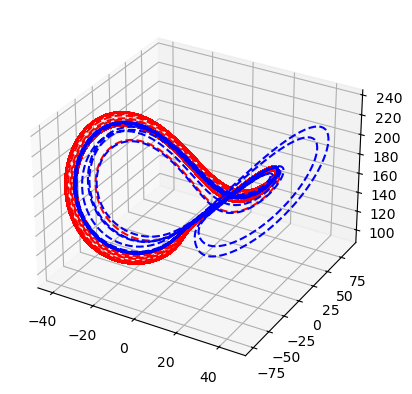

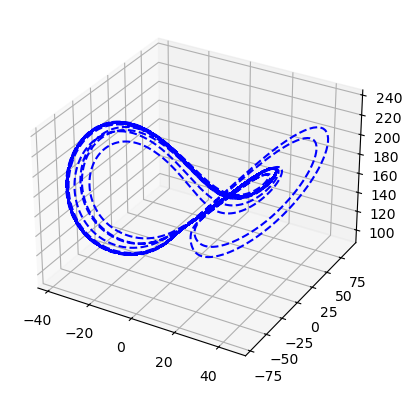

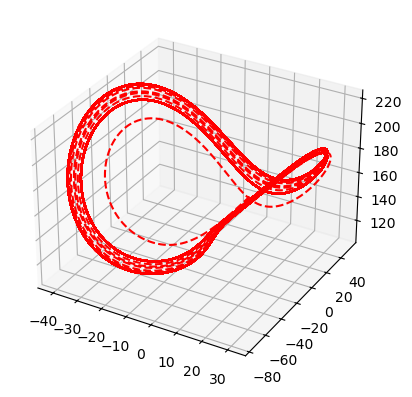

In [17]:
alphaseries = np.array([100])

#alphaseries = np.array([0.01, 1, 100, 1000, 2000, 3000])
avgseries = []
n = 1000  # reservoir size
m = 3

sigma = 10
rho = 160
beta = 8/3


mu = 1.2
lam = 0.000001

tau = 10

# Generate sparse reservoir matrix A1
A1 = sp.random(n, n, density=6/n, format='csr')
A1 = A1 - 0.5 * np.sign(A1.toarray())
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix
A = sp.csr_matrix(A1)

Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

r = 0.5 - 1.0 * np.random.rand(n)

x, y, z = -7.45, -3.03, 0.01

T = 100
dt = 0.002

ntraining = int(T / dt)

R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

for t in range(ntraining):
    
    u = np.array([x, y, z])
    R[:, t] = r

    fx = np.cos(0.05 * dt * t)
    fy = np.sin(0.05 * dt * t)
    f[0, t] = fx
    f[1, t] = fy

    xp = sigma * (y - x) + fx
    yp = x * (rho - z) - y + fy
    zp = x * y - beta * z

    x += dt * xp
    y += dt * yp
    z += dt * zp

    r = np.tanh(A.dot(r) + Win.dot(u) + 1)

Wout = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))

gtemp = np.array([x, y, z])

ndist = int(200 / dt)

for alpha in alphaseries:
    #np.random.seed(0)

    

    # xross = np.zeros(ndist + 1)
    # yross = np.zeros(ndist + 1)
    # zross = np.zeros(ndist + 1)

    # xross[0] = -7.45
    # yross[0] = -3.03
    # zross[0] = 0.01


    gx = np.zeros(ndist)
    gy = np.zeros(ndist)

    ux = np.zeros(ndist + 1)
    uy = np.zeros(ndist + 1)

    vx = np.zeros(ndist + 1)
    vy = np.zeros(ndist + 1)


    gpredx = np.zeros(ndist)
    gpredy = np.zeros(ndist)

    xplot = np.zeros(ndist)
    yplot = np.zeros(ndist)
    zplot = np.zeros(ndist)

    xplotwithout = np.zeros(ndist)
    yplotwithout = np.zeros(ndist)
    zplotwithout = np.zeros(ndist)

    xwithout, ywithout, zwithout = x, y, z

    for t in range(ndist):

        # xrossdot = - yross[t] - zross[t]
        # yrossdot = xross[t] + 0.2 * yross[t]
        # zrossdot = 0.2 + zross[t] * (xross[t] - 5.7)

        # xross[t + 1] = xross[t] + dt * xrossdot
        # yross[t + 1] = yross[t] + dt * yrossdot
        # zross[t + 1] = zross[t] + dt * zrossdot
    
        gy[t] = x

    
        ux[t] = gtemp[0] 
        uy[t] = gtemp[1]



        vx[t + 1] = vx[t] + dt / tau * (ux[t] - vx[t])
        vy[t + 1] = vy[t] + dt / tau * (uy[t] - vy[t])

        xp = sigma * (y - x) + gx[t] - alpha * vx[t]
        yp = x * (rho - z) - y + gy[t] - alpha * vy[t]
        zp = x * y - beta * z

        x += dt * xp
        y += dt * yp
        z += dt * zp
        
        xplot[t] = x
        yplot[t] = y
        zplot[t] = z

        xpwithout = sigma * (ywithout - xwithout) 
        ypwithout = xwithout * (rho - zwithout)
        zpwithout = xwithout * ywithout - beta * zwithout

        xwithout += dt * xpwithout
        ywithout += dt * ypwithout
        zwithout += dt * zpwithout
        
        xplotwithout[t] = xwithout
        yplotwithout[t] = ywithout
        zplotwithout[t] = zwithout

        gtemp = np.array([x, y, z])
        r = np.tanh(A.dot(r) + Win.dot(gtemp) + 1)
        gtemp = Wout.dot(r)
        gpredx[t] = gtemp[0]
        gpredy[t] = gtemp[1]


    pwithout = np.vstack((xplotwithout, yplotwithout, zplotwithout))
    pwith = np.vstack((xplot, yplot, zplot))
    pwithout = pwithout[:, -1000:]
    pwith = pwith[:, -1000:]

    sumdist = 0
    avg = 0
    for i in range(pwith.shape[1]):
        mindist = norm(pwith[:, i] - pwithout[:, 0])
        for j in range(pwithout.shape[1]):
            if norm(pwith[:, i] - pwithout[:, j]) < mindist :
                mindist = norm(pwith[:, i] - pwithout[:, j])
        sumdist += mindist

    avg = sumdist/pwith.shape[1]
    avgseries.append(avg)

avgseries = np.array(avgseries)

print(avgseries)


# fig = plt.figure()
# ax = plt.gca()
# ax.plot(alphaseries ,avgseries, 'o', c='blue', markeredgecolor='none')
# ax.set_yscale('log')
# ax.set_xscale('log')


plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xplot, yplot, zplot, 'r--')
ax.plot3D(xplotwithout, yplotwithout, zplotwithout, 'b--')
plt.show()

plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xplotwithout, yplotwithout, zplotwithout, 'b--')
plt.show()

plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xplot, yplot, zplot, 'r--')
plt.show()